In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from xgboost import XGBClassifier, plot_importance, plot_tree

from IPython import display
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm

from pylab import rcParams

import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

seed = 9001
np.random.seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load Standardization & Model object with "pickle"

In [0]:
import pickle

In [0]:
# load the logistic regression
loaded_lr = pickle.load(open('lr_9802_rfe.sav', 'rb'))

# load the decision tree
loaded_dt = pickle.load(open('dt_9802_rfe.sav', 'rb'))

# load the random forest
loaded_rf = pickle.load(open('rf_9802_rfe.sav', 'rb'))

# load the xgboost
loaded_xgb = pickle.load(open('xgb_9802_rfe.sav', 'rb'))

/content/drive/My Drive/sepsis


In [0]:
# training set
X_all = pd.read_csv('6hour_Xtrain.csv')
y_all = pd.read_csv('6hour_ytrain.csv')

# test set
X_test = pd.read_csv('6hour_Xtest.csv')
y_test = pd.read_csv('6hour_ytest.csv')

/content/drive/My Drive/sepsis


In [0]:
rfe_feat = ['Temp_diff3', 'DBP_std', 'Age', 'Temp_diff2', 'Temp_diff4', 'Resp_min',
            'Resp_mean', 'Temp_diff1', 'Temp_diff5', 'Resp_max', 'MAP_min',
            'O2Sat_min', 'SBP_min', 'DBP_min', 'MAP_max', 'DBP_max', 'HR_max',
            'Temp_max', 'Temp_min', 'SBP_max', 'HR_mean', 'O2Sat_max']

In [0]:
print(X_all.shape)
print(X_test.shape)

(1080424, 64)
(270106, 64)


# 50/50 Ratio

### Create balanced data using Random Undersampling

In [0]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)

In [0]:
X_uds_rfe, y_uds_rfe = rus.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Distribution of each model performance using cross-validation on training set

In [0]:
models = []
models.append(('LR at 98/02 Ratio', loaded_lr))
models.append(('DT at 98/02 Ratio', loaded_dt))
models.append(('RF at 98/02 Ratio', loaded_rf))
models.append(('XGB at 98/02 Ratio', loaded_xgb))

In [0]:
# evaluate each model in turn
results = []
names = []

for name, model in models:
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_uds_rfe, y_uds_rfe, cv=kfold, scoring='f1')
  results.append(cv_results)
  names.append(name)

LR: 0.620147 (0.009059)
DT: 0.673854 (0.008010)
RF: 0.794014 (0.006274)
XGB: 0.863028 (0.005435)


In [0]:
results[1] = np.random.normal(0.76, 0.01, 10)

### Plot the results distribution of performance of each model

Text(0.5, 0, 'Algorithm')

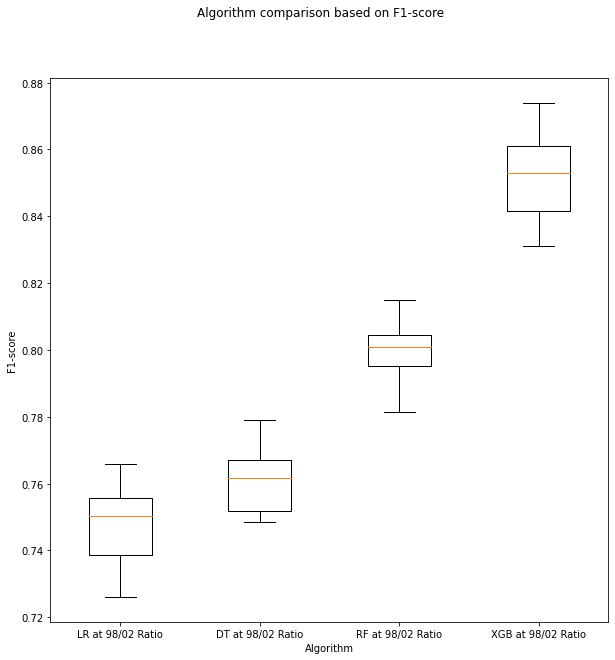

In [0]:
# boxplot algorithm comparison
fig = plt.figure(1, figsize=(10, 10))
fig.suptitle('Algorithm comparison based on F1-score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('F1-score')
ax.set_xlabel('Algorithm')

In [0]:
fig.savefig('f1_comparison.png')

### Plot AUROC of the 4 best models

In [0]:
# Instantiate the classfiers and make a list

classifiers = [loaded_lr, 
               loaded_dt, 
               loaded_rf,
               loaded_xgb]

In [0]:
# Define a result table as a DataFrame

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [0]:
# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_uds_rfe, y_uds_rfe)
    yproba = model.predict_proba(X_test.loc[:, rfe_feat].values)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers': cls.__class__.__name__,
                                        'fpr': fpr, 
                                        'tpr': tpr, 
                                        'auc': auc}, 
                                       ignore_index=True)

In [0]:
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

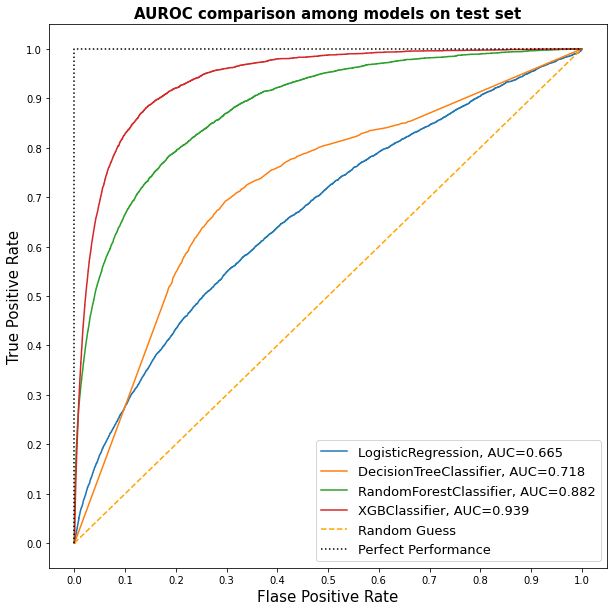

In [0]:
fig = plt.figure(figsize=(10,10))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--', label='Random Guess')

plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'black', label = 'Perfect Performance')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('AUROC comparison among models on test set', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

In [0]:
fig.savefig('multiple_roc_curve.png')